In [45]:
import os, sys
import pandas as pd
import numpy as np
import datetime as dt
from pprint import pprint
import csv
import itertools as it
from prettytable import PrettyTable
import matplotlib.pylab as plt
import seaborn as sns
import portion as P
from collections import namedtuple
import math

DataFrame = namedtuple('DataFrame', 'filename, df', defaults=tuple([None]*2))

pdir = os.path.abspath(os.path.join(os.getcwd(), '..'))  # for jupyter-notebook
sys.path.insert(1, pdir)
from myutils import *

%config InlineBackend.figure_format = 'retina'  # 提高 jupyter notebook 的圖形顯示解析度
# plt.style.use('ggplot')

pd.set_option('display.max_columns', 200)
# pd.set_option('display.max_rows', 200)

def set_data(df):
    df['seq'] = df['seq'].astype('Int32')
    df['rpkg'] = df['rpkg'].astype('Int8')
    df['frame_id'] = df['frame_id'].astype('Int32')
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df['xmit_time'] = pd.to_datetime(df['xmit_time'])
    df['arr_time'] = pd.to_datetime(df['arr_time'])
    df['Timestamp_epoch'] = df['Timestamp_epoch'].astype('float32')
    df['xmit_time_epoch'] = df['xmit_time_epoch'].astype('float32')
    df['arr_time_epoch'] = df['arr_time_epoch'].astype('float32')
    df['lost'] = df['lost'].astype('boolean')
    df['excl'] = df['excl'].astype('boolean')
    df['latency'] = df['latency'].astype('float32')
    return df

In [46]:
datadir = "/Users/jackbedford/Desktop/MOXA/Code/data"
exps = {
    "2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q": ['#{:02d}'.format(i+1) for i in range(12)],
    "2023-03-26/_Bandlock_Udp_All_RM500Q": ['#{:02d}'.format(i+1) for i in range(4)],
    "2023-04-01/_Bandlock_Udp_B1_B3_B7_B8_RM500Q": ['#{:02d}'.format(i+1) for i in range(6)],
    "2023-04-01/_Bandlock_Udp_B1B3_B1B8_LTE_All_RM500Q": ['#{:02d}'.format(i+1) for i in range(4)],
    "2023-04-10/_Bandlock_Udp_All_RM500Q": ['#{:02d}'.format(i+1) for i in range(2)],
    "2023-04-10/_Bandlock_Udp_B1_B3_B7_B8_RM500Q": ['#{:02d}'.format(i+1) for i in range(2)],
    "2023-04-10/_Bandlock_Udp_LTE_All_B7B8_B7_RM500Q": ['#{:02d}'.format(i+1) for i in range(2)],
    "2023-04-17/_Bandlock_Udp_All_LTE_B1B3_B3B7_RM500Q": ['#{:02d}'.format(i+1) for i in range(2)], # trace03-04 abnormal
    "2023-04-17/_Bandlock_Udp_All_LTE_B1B7_B7B8_RM500Q": ['#{:02d}'.format(i+1) for i in range(4)],
    "2023-04-17/_Bandlock_Udp_All_LTE_B1B8_B3B8_RM500Q": ['#{:02d}'.format(i+1) for i in range(4)],
    "2023-04-17/_Bandlock_Udp_All_LTE_RM500Q": ['#{:02d}'.format(i+1) for i in range(4)],
    "2023-04-17/_Bandlock_Udp_All_LTE_B1_B3_RM500Q": ['#{:02d}'.format(i+1) for i in range(2)],
    "2023-04-17/_Bandlock_Udp_All_LTE_B7_B8_RM500Q": ['#{:02d}'.format(i+1) for i in range(2)],
}
_devices = [
    ['qc00','qc02','qc03'],
    ['qc00','qc02','qc03'],
    ['qc00','qc01','qc02','qc03'],
    ['qc00','qc01','qc02','qc03'],
    ['qc00','qc02','qc03'],
    ['qc00','qc02','qc03'],
    ['qc00','qc01','qc02','qc03'],
    ['qc00','qc02','qc03'],
    ['qc00','qc02','qc03'],
    ['qc00','qc02','qc03'],
    ['qc00','qc02','qc03'],
    ['qc00','qc02','qc03'],
    ['qc00','qc02','qc03'],
]
_schemes = [
    ['B1','B7','B8'],
    ['All@00','All@02','All@03'],
    ['B1','B3','B7','B8'],
    ['B1B3','B1B8','LTE','All'],
    ['All@00','All@02','All@03'],
    ['B1','B7','B8'],
    ['LTE','All','B7B8','B7'],
    ['All','B1B3','B3B7'],
    ['All','B1B7','B7B8'],
    ['All','B1B8','B3B8'],
    ['All@00','All@02','LTE@03'],
    ['All','B1','B3'],
    ['All','B7','B8'],
]

In [47]:
def cut_head_tail(df_HO, df, mode='ul'):
    if mode == 'ul':
        start = df.iloc[0].xmit_time
        stop = df.iloc[-1].xmit_time
        df_HO = df_HO.query('Timestamp >= @start & Timestamp <= @stop').copy().reset_index(drop=True)
    if mode == 'dl':
        start = df.iloc[0].arr_time
        stop = df.iloc[-1].arr_time
        df_HO = df_HO.query('Timestamp >= @start & Timestamp <= @stop').copy().reset_index(drop=True)
    return df_HO

def is_disjoint(set1, set2):
    """
    Check if two sets are disjoint.
    """
    return (set1 & set2).empty

def is_disjoint_dict(E):
    test_intv = P.empty()
    for key, val in E.items():
        # print(key)
        for intv in val:
            if is_disjoint(test_intv, intv.interval):
                test_intv = test_intv | intv.interval
            else:
                print(key, intv.index)
                return False
    return True

def interp(x, y, ratio):
    """
    Interpolation

    Args:
        x, y (datetime.datetime): x < y
        ratio (float): a decimal numeral in a range [0, 1]; 0 means break at x, 1 means break at y.
    Returns:
        (datetime.datetime): breakpoint of interpolation
    """
    return x + (y - x) * ratio

In [48]:
sorter = ['LTE_HO','MN_HO','SN_HO','MNSN_HO','SN_Rel','SN_Setup','SN_Rel_MN_HO','SN_Setup_MN_HO',
          'SCG_Failure_t310-Expiry (0)','SCG_Failure_randomAccessProblem (1)','SCG_Failure_rlc-MaxNumRetx (2)','SCG_Failure_synchReconfigFailureSCG (3)',
          'SCG_Failure_scg-ReconfigFailure (4)','SCG_Failure_srb3-IntegrityFailure (5)','SCG_Failure_other-r16 (6)',
          'MCG_Failure_reconfigurationFailure (0)','MCG_Failure_handoverFailure (1)','MCG_Failure_otherFailure (2)',
          'NAS_Recovery_reconfigurationFailure (0)','NAS_Recovery_handoverFailure (1)','NAS_Recovery_otherFailure (2)']

ImpactScope = {
    'LTE_HO': (1.2, 1), 
    'MN_HO': (1.4, 2),
    'SN_HO': (0.9, 1.3),
    'SN_Setup': (0.4, 1.7),
    'SN_Rel': (0.2, 0.2),
    'SN_Rel_MN_HO': (0.4, 0.6),
    'SCG_Failure_t310-Expiry (0)': (1.5, 1.2),
    'SCG_Failure_synchReconfigFailureSCG (3)': (0.1, 0.1),
    'MCG_Failure_handoverFailure (1)': (0.8, 1.3),
    'MCG_Failure_otherFailure (2)': (5.7, 1.5),
    'NAS_Recovery_handoverFailure (1)': (0.5, 0.5),
    'NAS_Recovery_otherFailure (2)': (0.8, 1.6)
}

def get_ho_interval(df, sec=(1, 3), ratio=0.5,
                 ignored=['Conn_Setup','Conn_Rel'],
                 handover=['LTE_HO','MN_HO','SN_HO','SN_Setup','SN_Rel','SN_Rel_MN_HO'],
                 linkfailure=['SCG_Failure_t310-Expiry (0)','SCG_Failure_synchReconfigFailureSCG (3)',
                              'MCG_Failure_handoverFailure (1)','MCG_Failure_otherFailure (2)',
                              'NAS_Recovery_handoverFailure (1)','NAS_Recovery_otherFailure (2)']):
    
    HO_INTV = namedtuple('HO_INTV', 'index, interval, state1, state2, st_scel, cause, interrupt, \
                                     ePCI, earfcn, nrPCI, ePCI1, earfcn1, nrPCI1', defaults=tuple([None]*12))
    
    def ignore_col(row):
        if row.ho_type in ignored:
            return False
        else:
            return True
    df = df[df.apply(ignore_col, axis=1)].reset_index(drop=True)
    
    column_names = []
    for type_name in handover + linkfailure:
        column_names += ["before_{}".format(type_name), "during_{}".format(type_name), "after_{}".format(type_name)]
    E = { col:[] for col in column_names }
    
    for i, row in df.iterrows():
        prior_row = df.iloc[i-1] if i != 0 else None
        post_row = df.iloc[i+1] if i != len(df)-1 else None
        ### peek the next event
        if i != len(df)-1 and pd.notna(row.end) and row.end > post_row.start:
            print(i, row.start, row.end, row.ho_type, row.cause)
            print(i+1, post_row.start, post_row.end, post_row.ho_type, post_row.cause)
            continue
        ### peri_interval
        if pd.isna(row.end):
            peri_interval = P.singleton(row.start)
        else:
            peri_interval = P.closed(row.start, row.end)
        ### prior_interval
        type_name = row.ho_type if row.ho_type not in ['SCG_Failure','MCG_Failure','NAS_Recovery'] else row.ho_type + '_' + row.cause
        C = row.start - pd.Timedelta(seconds=ImpactScope[type_name][0])
        D = row.start
        prior_interval = P.closedopen(C, D)
        if ratio != None and i != 0:
            type_name = prior_row.ho_type if prior_row.ho_type not in ['SCG_Failure','MCG_Failure','NAS_Recovery'] else prior_row.ho_type + '_' + prior_row.cause
            A = max(prior_row.start, prior_row.end)
            B = max(prior_row.start, prior_row.end) + pd.Timedelta(seconds=ImpactScope[type_name][1])
            if P.openclosed(A, B).overlaps(prior_interval):
                # print("Overlaps with the previous!")
                bkp = interp(C, B, ratio)
                bkp = max(bkp, A)  # to avoid the breakpoint overlaps the previous event's duration
                # bkp = min(max(bkp, A), D)  # 我不侵犯到其他任何人，代表其他人也不會侵犯到我！
                prior_interval = P.closedopen(bkp, D)
                if A in prior_interval:
                    prior_interval = P.open(bkp, D)
                # blindly set as open inverval is fine, but may miss one point.
        ### post_interval
        type_name = row.ho_type if row.ho_type not in ['SCG_Failure','MCG_Failure','NAS_Recovery'] else row.ho_type + '_' + row.cause
        C = row.end
        D = row.end + pd.Timedelta(seconds=ImpactScope[type_name][1])
        post_interval = P.openclosed(C, D)
        if ratio != None and i != len(df)-1:
            type_name = post_row.ho_type if post_row.ho_type not in ['SCG_Failure','MCG_Failure','NAS_Recovery'] else post_row.ho_type + '_' + post_row.cause
            A = min(post_row.start, post_row.end) - pd.Timedelta(seconds=ImpactScope[type_name][0])
            B = min(post_row.start, post_row.end)
            if P.closedopen(A, B).overlaps(post_interval):
                # print("Overlaps with the following!")
                bkp = interp(A, D, ratio)
                bkp = min(bkp, B)  # to avoid the breakpoint overlaps the following event's duration
                # bkp = max(min(bkp, B), C)  # 我不侵犯到其他任何人，代表其他人也不會侵犯到我！
                post_interval = P.open(C, bkp)
        ### append dictionary
        type_name = row.ho_type if row.ho_type not in ['SCG_Failure','MCG_Failure','NAS_Recovery'] else row.ho_type + '_' + row.cause
        state1, state2 = 'sn_change', 'sn_change'
        if type_name in linkfailure:
            state1, state2 = 'link_failure', 'link_failure'
        if type_name in ['LTE_HO','MN_HO','SN_Rel_MN_HO']:
            state1 = 'inter_freq' if row.sFreq != row.tFreq else 'intra_freq'
            if pd.notna(row.eNB) and pd.notna(row.eNB1) and row.eNB != row.eNB1:
                state2 = 'inter_enb'
            elif row.sPCI != row.tPCI:
                state2 = 'inter_sector'
            elif row.sPCI == row.tPCI:
                state2 = 'intra_sector'
            else:
                print("************** inter_enb, unknown eNB_ID **************")
                state2 = 'inter_enb'
        E[f'before_{type_name}'].append(HO_INTV(i, prior_interval, state1, state2, row.st_scel, row.cause, row.intr, row.sPCI, row.sFreq, row.snrPCI, row.tPCI, row.tFreq, row.tnrPCI))
        E[f'during_{type_name}'].append(HO_INTV(i, peri_interval, state1, state2, row.st_scel, row.cause, row.intr, row.sPCI, row.sFreq, row.snrPCI, row.tPCI, row.tFreq, row.tnrPCI))
        E[f'after_{type_name}'].append(HO_INTV(i, post_interval, state1, state2, row.st_scel, row.cause, row.intr, row.sPCI, row.sFreq, row.snrPCI, row.tPCI, row.tFreq, row.tnrPCI))
        ### check whether the intervals are pairwise disjoint
        if not is_disjoint_dict(E):
            print('Warning: Intervals are not totally disjoint!')
    return E

def label_ho_info(df, E, mode='ul'):
    def removeprefix(string, prefix=['before','during','after']):
        for pref in prefix:
            if string.startswith(pref):
                return pref, string[len(pref)+1:]
        return None, string
    
    df = df.reindex(columns=[*list(df.columns),
            'ho_index','ho_stage','ho_type','ho_type1','ho_type2','ho_scel','ho_cause','ho_intr',
            'ho_ePCI','ho_earfcn','ho_nrPCI','ho_ePCI1','ho_earfcn1','ho_nrPCI1'])
    
    df[['ho_index','ho_stage','ho_type','ho_type1','ho_type2','ho_scel','ho_cause','ho_intr',
        'ho_ePCI','ho_earfcn','ho_nrPCI','ho_ePCI1','ho_earfcn1','ho_nrPCI1']] = \
        [-1, '-', 'stable', 'stable', 'stable', 0, None, None,
         None, None, None, None, None, None]
            
    for key, val in E.items():
        pref, key = removeprefix(key)
        for intv in val:
            if intv.interval.empty:
                continue
            # print(pref, key)
            # print(intv.interval)
            if mode == 'ul':
                df.loc[(df['xmit_time'] >= intv.interval.lower) & (df['xmit_time'] <= intv.interval.upper),
                       ('ho_index','ho_stage','ho_type','ho_type1','ho_type2','ho_scel','ho_cause','ho_intr',
                        'ho_ePCI','ho_earfcn','ho_nrPCI','ho_ePCI1','ho_earfcn1','ho_nrPCI1')] = \
                        [intv.index, pref, key, intv.state1, intv.state2, intv.st_scel, intv.cause, intv.interrupt,
                        intv.ePCI, intv.earfcn, intv.nrPCI, intv.ePCI1, intv.earfcn1, intv.nrPCI1]
            if mode == 'dl':
                df.loc[(df['arr_time'] >= intv.interval.lower) & (df['arr_time'] <= intv.interval.upper),
                       ('ho_index','ho_stage','ho_type','ho_type1','ho_type2','ho_scel','ho_cause','ho_intr',
                        'ho_ePCI','ho_earfcn','ho_nrPCI','ho_ePCI1','ho_earfcn1','ho_nrPCI1')] = \
                        [intv.index, pref, key, intv.state1, intv.state2, intv.st_scel, intv.cause, intv.interrupt,
                        intv.ePCI, intv.earfcn, intv.nrPCI, intv.ePCI1, intv.earfcn1, intv.nrPCI1]
    
    df['ho_type0'] = df['ho_type']
    df.loc[np.in1d(df['ho_type'], ['SCG_Failure','MCG_Failure','NAS_Recovery']), 'ho_type0'] = \
        df.loc[np.in1d(df['ho_type'], ['SCG_Failure','MCG_Failure','NAS_Recovery']), 'ho_type'] + '_' + df.loc[np.in1d(df['ho_type'], ['SCG_Failure','MCG_Failure','NAS_Recovery']), 'ho_cause']
    
    df['_ho_type'] = df['ho_type']
    df['_ho_type0'] = df['ho_type0']
    df['_ho_type1'] = df['ho_type1']
    df['_ho_type2'] = df['ho_type2']
    df.loc[~np.in1d(df['ho_type'], ['stable']), '_ho_type'] = df.loc[~np.in1d(df['ho_type'], ['stable']), 'ho_stage'] + '_' + df.loc[~np.in1d(df['ho_type'], ['stable']), 'ho_type']
    df.loc[~np.in1d(df['ho_type'], ['stable']), '_ho_type0'] = df.loc[~np.in1d(df['ho_type'], ['stable']), 'ho_stage'] + '_' + df.loc[~np.in1d(df['ho_type'], ['stable']), 'ho_type0']
    df.loc[~np.in1d(df['ho_type'], ['stable']), '_ho_type1'] = df.loc[~np.in1d(df['ho_type'], ['stable']), 'ho_stage'] + '_' + df.loc[~np.in1d(df['ho_type'], ['stable']), 'ho_type1']
    df.loc[~np.in1d(df['ho_type'], ['stable']), '_ho_type2'] = df.loc[~np.in1d(df['ho_type'], ['stable']), 'ho_stage'] + '_' + df.loc[~np.in1d(df['ho_type'], ['stable']), 'ho_type2']
    
    df['ho_index'] = df['ho_index'].astype('Int32')
    df['ho_stage'] = df['ho_stage'].astype('category')
    df['ho_type'] = df['ho_type'].astype('category')
    df['ho_type0'] = df['ho_type0'].astype('category')
    df['ho_type1'] = df['ho_type1'].astype('category')
    df['ho_type2'] = df['ho_type2'].astype('category')
    df['ho_scel'] = df['ho_scel'].astype('Int8')
    df['ho_cause'] = df['ho_cause'].astype('category')
    df['ho_intr'] = df['ho_intr'].astype('float32')
    for tag in df.columns[df.columns.get_loc('ho_ePCI'):df.columns.get_loc('ho_nrPCI1')+1]:
        df[tag] = df[tag].astype('Int32')
    df['_ho_type'] = df['_ho_type'].astype('category')
    df['_ho_type0'] = df['_ho_type'].astype('category')
    df['_ho_type1'] = df['_ho_type1'].astype('category')
    df['_ho_type2'] = df['_ho_type2'].astype('category')
    
    return df

In [52]:
# Initialization
handover=['LTE_HO','MN_HO','SN_HO','SN_Setup','SN_Rel','SN_Rel_MN_HO']
linkfailure=['SCG_Failure_t310-Expiry (0)','SCG_Failure_synchReconfigFailureSCG (3)',
            'MCG_Failure_handoverFailure (1)','MCG_Failure_otherFailure (2)',
            'NAS_Recovery_handoverFailure (1)','NAS_Recovery_otherFailure (2)']
column_names = []
for type_name in [*handover, *linkfailure]:
    column_names += ["before_{}".format(type_name), "during_{}".format(type_name), "after_{}".format(type_name)]
DD = { col:[0, 0, 0, 0, 0] for col in column_names }
DD['stable'] = [0,0,0,0,0]

for (exp, traces), devices, schemes in zip(exps.items(), _devices, _schemes):
    for trace in traces:
        for j, (dev, schm) in enumerate(zip(devices, schemes)):
            ## read uplink
            data = os.path.join(datadir, exp, dev, trace, 'data', 'udp_uplk_loss_latency.csv')
            print(data, os.path.isfile(data))
            df_ul = pd.read_csv(data)
            df_ul = set_data(df_ul)
            ## read downlink
            data = os.path.join(datadir, exp, dev, trace, 'data', 'udp_dnlk_loss_latency.csv')
            print(data, os.path.isfile(data))
            df_dl = pd.read_csv(data)
            df_dl = set_data(df_dl)
            ## read handover
            path = os.path.join(datadir, exp, dev, trace, 'data')
            data = os.path.join(path, [s for s in os.listdir(path) if s.startswith('diag_log_') and s.endswith('_rrc.csv')][0])
            print(data, os.path.isfile(data))
            df_ho = pd.read_csv(data)
            df_ho, _, _ = mi_parse_ho(df_ho, tz=8)
            df_ho['ho_type0'] = df_ho['ho_type'].astype('string')
            df_ho.loc[df_ho['cause'].notna(), 'ho_type0'] = df_ho['ho_type'].astype('string') + '_' + df_ho['cause'].astype('string')
            df_ho['ho_type0'] = df_ho['ho_type0'].astype('category')

            # Sample
            for tag in [*handover, *linkfailure]:
                n = len(df_ho[df_ho['ho_type0'] == tag])
                DD[f'before_{tag}'][0] += n
                DD[f'during_{tag}'][0] += n
                DD[f'after_{tag}'][0] += n
            E = get_ho_interval(df_ho.copy())

            df = label_ho_info(df_ul.copy(), E, mode='ul')
            for tag in sorter:
                u = df[df['ho_type'] == tag]
                if len(u) == 0:
                    continue
                x = u[u['ho_stage'] == 'before']
                y = u[u['ho_stage'] == 'during']
                z = u[u['ho_stage'] == 'after']
                # print(tag)
                # print(len(u), sum(u['lost']))
                DD[f'before_{tag}'][1] += len(x)
                DD[f'before_{tag}'][2] += sum(x['lost'])
                DD[f'during_{tag}'][1] += len(y)
                DD[f'during_{tag}'][2] += sum(y['lost'])
                DD[f'after_{tag}'][1] += len(z)
                DD[f'after_{tag}'][2] += sum(z['lost'])
            u = df[df['ho_type'] == 'stable']
            DD['stable'][1] += len(u)
            DD['stable'][2] += sum(u['lost'])

            df = label_ho_info(df_dl.copy(), E, mode='dl')
            for tag in sorter:
                u = df[df['ho_type'] == tag]
                if len(u) == 0:
                    continue
                x = u[u['ho_stage'] == 'before']
                y = u[u['ho_stage'] == 'during']
                z = u[u['ho_stage'] == 'after']
                # print(tag)
                # print(len(u), sum(u['lost']))
                DD[f'before_{tag}'][3] += len(x)
                DD[f'before_{tag}'][4] += sum(x['lost'])
                DD[f'during_{tag}'][3] += len(y)
                DD[f'during_{tag}'][4] += sum(y['lost'])
                DD[f'after_{tag}'][3] += len(z)
                DD[f'after_{tag}'][4] += sum(z['lost'])
            u = df[df['ho_type'] == 'stable']
            DD['stable'][1] += len(u)
            DD['stable'][2] += sum(u['lost'])

/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#01/data/udp_uplk_loss_latency.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#01/data/udp_dnlk_loss_latency.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#01/data/diag_log_qc00_2023-03-16_19-23-29_rrc.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc02/#01/data/udp_uplk_loss_latency.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc02/#01/data/udp_dnlk_loss_latency.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc02/#01/data/diag_log_qc02_2023-03-16_19-23-29_rrc.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc03/#01/data/udp_uplk_loss_latency.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-1

In [53]:
DD

{'before_LTE_HO': [537, 274298, 101, 273245, 52],
 'during_LTE_HO': [537, 4364, 1, 4310, 2],
 'after_LTE_HO': [537, 216801, 127, 217853, 653],
 'before_MN_HO': [2134, 1002957, 1407, 1003595, 7788],
 'during_MN_HO': [2134, 18232, 35, 18307, 447],
 'after_MN_HO': [2134, 1456364, 3719, 1454053, 22731],
 'before_SN_HO': [2216, 679488, 589, 677055, 349],
 'during_SN_HO': [2216, 15886, 25, 15890, 142],
 'after_SN_HO': [2216, 1051320, 1392, 1052799, 4997],
 'before_SN_Setup': [567, 6124, 100, 5913, 278],
 'during_SN_Setup': [567, 7971, 155, 8233, 1765],
 'after_SN_Setup': [567, 357222, 7520, 361172, 48896],
 'before_SN_Rel': [12, 226, 9, 200, 15],
 'during_SN_Rel': [12, 164, 0, 122, 12],
 'after_SN_Rel': [12, 85, 0, 70, 0],
 'before_SN_Rel_MN_HO': [301, 29920, 2, 29550, 8],
 'during_SN_Rel_MN_HO': [301, 4652, 26, 4409, 230],
 'after_SN_Rel_MN_HO': [301, 33680, 425, 32360, 1622],
 'before_SCG_Failure_t310-Expiry (0)': [3, 2050, 0, 1805, 972],
 'during_SCG_Failure_t310-Expiry (0)': [3, 0, 0, 0,

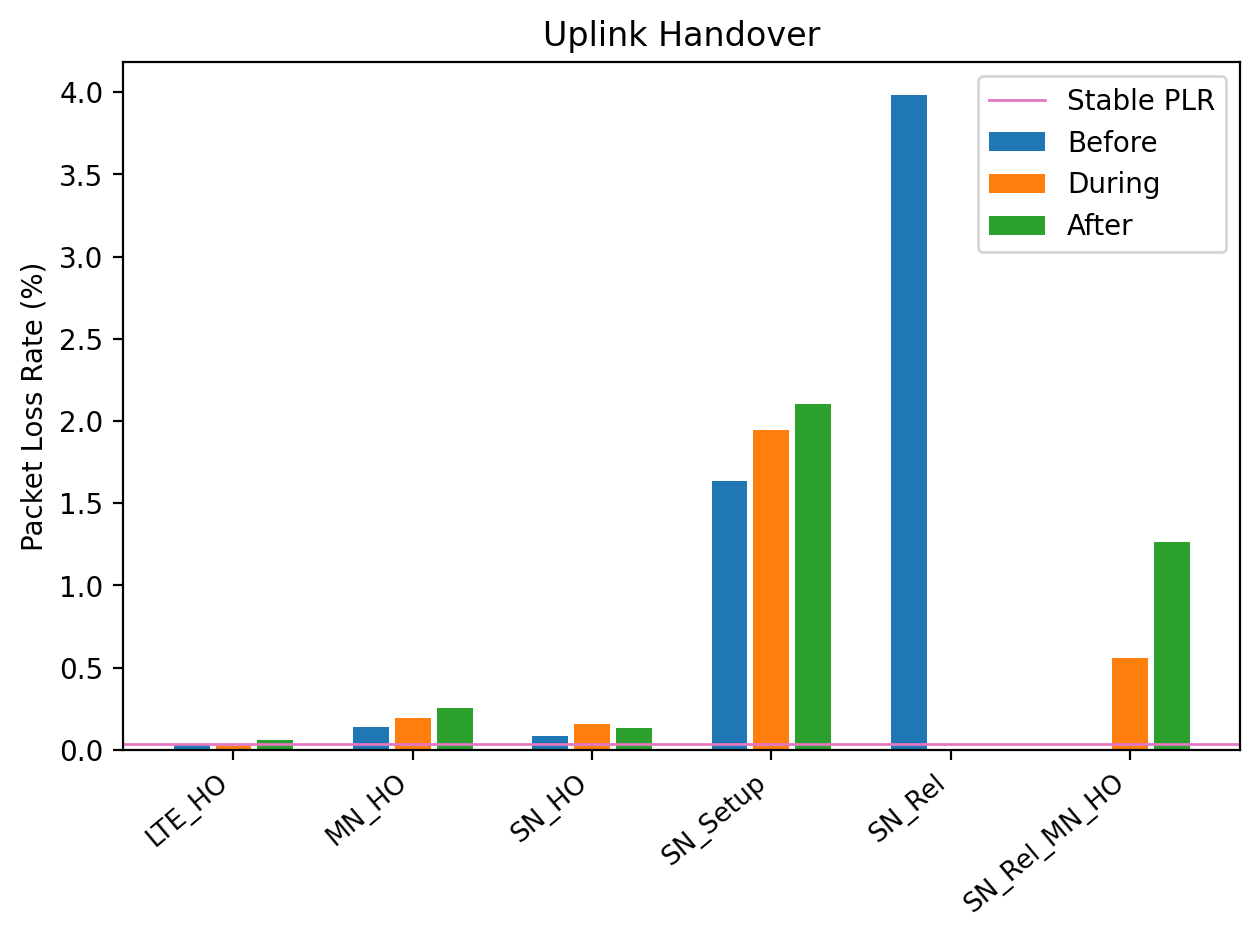

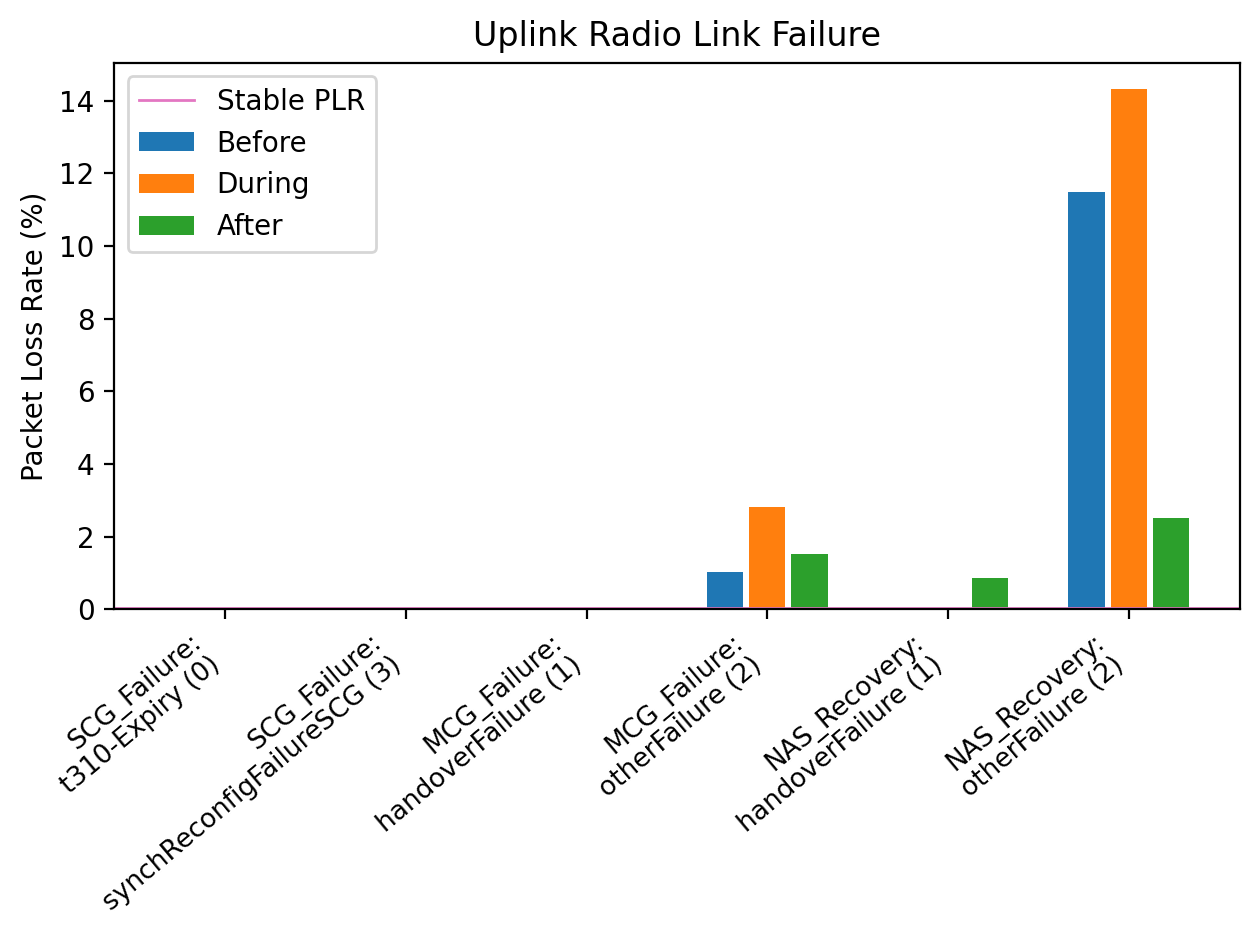

In [65]:
labels = ['LTE_HO','MN_HO','SN_HO','SN_Setup','SN_Rel','SN_Rel_MN_HO']
before_event_loss_rate = [DD[f'before_{tag}'][2] / (DD[f'before_{tag}'][1] + 1e-9) * 100 for tag in labels]
during_event_loss_rate = [DD[f'during_{tag}'][2] / (DD[f'during_{tag}'][1] + 1e-9) * 100 for tag in labels]
after_event_loss_rate = [DD[f'after_{tag}'][2] / (DD[f'after_{tag}'][1] + 1e-9) * 100 for tag in labels]

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars
space = 0.7

fig, ax = plt.subplots()
rects1 = ax.bar(x - space/3, before_event_loss_rate, width, label='Before')
rects2 = ax.bar(x          , during_event_loss_rate, width, label='During')
rects3 = ax.bar(x + space/3, after_event_loss_rate, width, label='After')
ax.axhline(DD['stable'][2] / (DD['stable'][1] + 1e-9) * 100, c = 'tab:pink', linewidth=1, label='Stable PLR')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Packet Loss Rate (%)')
ax.set_title('Uplink Handover')
ax.legend()

ax.set_xticks(x, labels)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

# ax.set_ylim(top=round(max(classif_3_df['packet_loss_rate(%)'].iloc[:24]) + 0.2, 1))
# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)
# ax.bar_label(rects3, padding=3)

fig.tight_layout()

plt.show()

labels = ['SCG_Failure_t310-Expiry (0)','SCG_Failure_synchReconfigFailureSCG (3)',
            'MCG_Failure_handoverFailure (1)','MCG_Failure_otherFailure (2)',
            'NAS_Recovery_handoverFailure (1)','NAS_Recovery_otherFailure (2)']
before_event_loss_rate = [DD[f'before_{tag}'][2] / (DD[f'before_{tag}'][1] + 1e-9) * 100 for tag in labels]
during_event_loss_rate = [DD[f'during_{tag}'][2] / (DD[f'during_{tag}'][1] + 1e-9) * 100 for tag in labels]
after_event_loss_rate = [DD[f'after_{tag}'][2] / (DD[f'after_{tag}'][1] + 1e-9) * 100 for tag in labels]

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars
space = 0.7

fig, ax = plt.subplots()
rects1 = ax.bar(x - space/3, before_event_loss_rate, width, label='Before')
rects2 = ax.bar(x          , during_event_loss_rate, width, label='During')
rects3 = ax.bar(x + space/3, after_event_loss_rate, width, label='After')
ax.axhline(DD['stable'][2] / (DD['stable'][1] + 1e-9) * 100, c = 'tab:pink', linewidth=1, label='Stable PLR')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Packet Loss Rate (%)')
ax.set_title('Uplink Radio Link Failure')
ax.legend()

labels = ['SCG_Failure:\nt310-Expiry (0)','SCG_Failure:\nsynchReconfigFailureSCG (3)',
            'MCG_Failure:\nhandoverFailure (1)','MCG_Failure:\notherFailure (2)',
            'NAS_Recovery:\nhandoverFailure (1)','NAS_Recovery:\notherFailure (2)']

ax.set_xticks(x, labels)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

# ax.set_ylim(top=round(max(classif_3_df['packet_loss_rate(%)'].iloc[:24]) + 0.2, 1))
# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)
# ax.bar_label(rects3, padding=3)

fig.tight_layout()

plt.show()

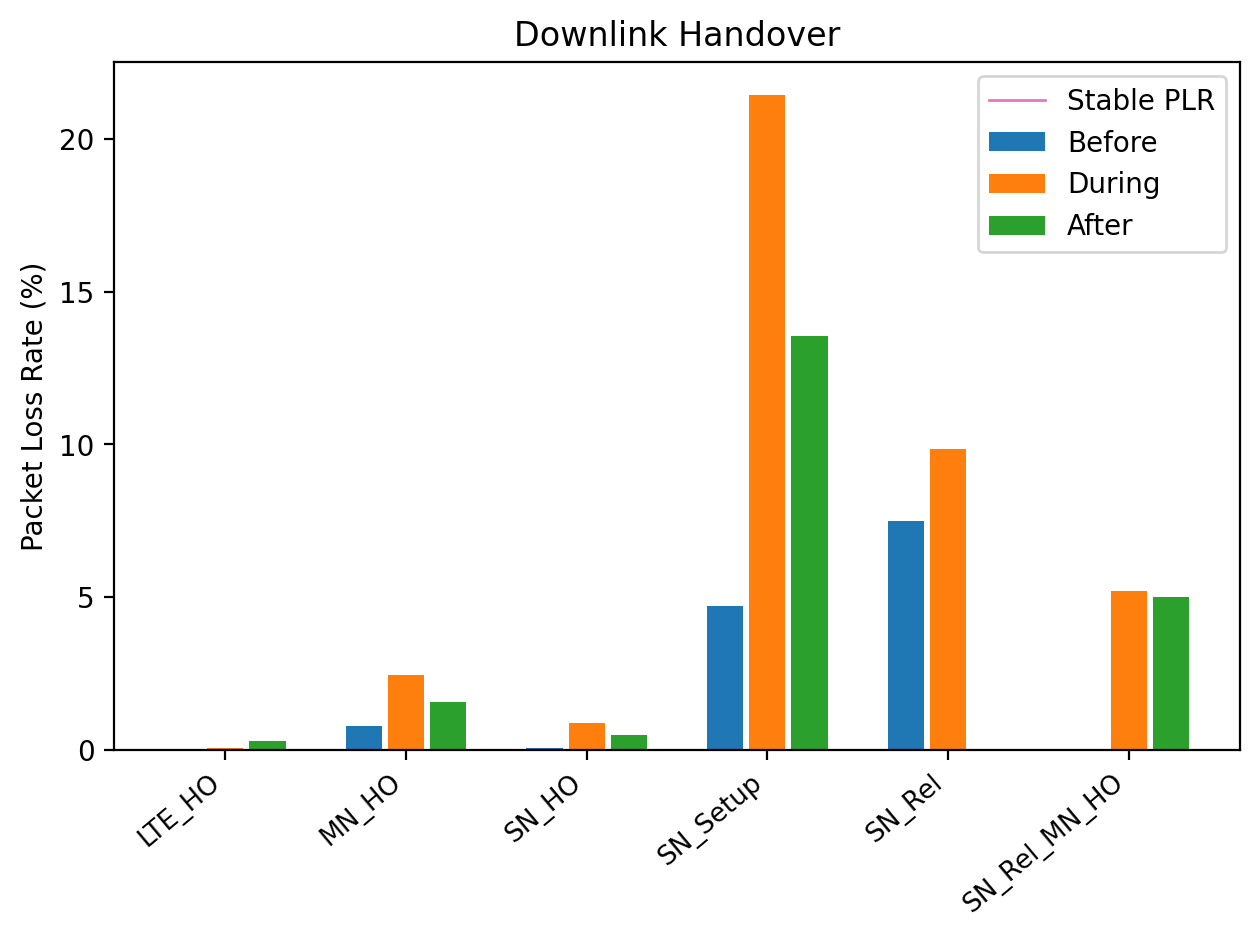

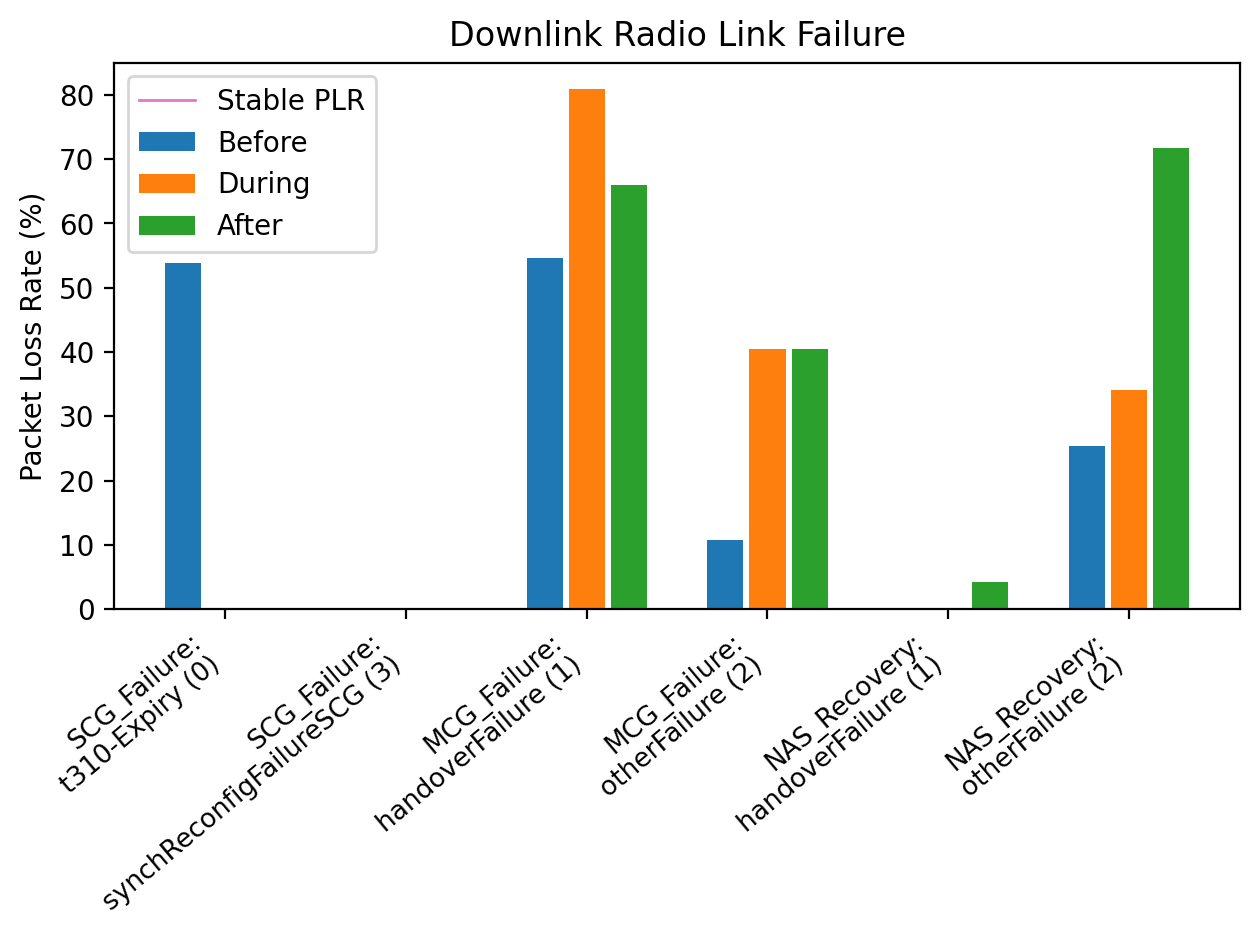

In [66]:
labels = ['LTE_HO','MN_HO','SN_HO','SN_Setup','SN_Rel','SN_Rel_MN_HO']
before_event_loss_rate = [DD[f'before_{tag}'][4] / (DD[f'before_{tag}'][3] + 1e-9) * 100 for tag in labels]
during_event_loss_rate = [DD[f'during_{tag}'][4] / (DD[f'during_{tag}'][3] + 1e-9) * 100 for tag in labels]
after_event_loss_rate = [DD[f'after_{tag}'][4] / (DD[f'after_{tag}'][3] + 1e-9) * 100 for tag in labels]

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars
space = 0.7

fig, ax = plt.subplots()
rects1 = ax.bar(x - space/3, before_event_loss_rate, width, label='Before')
rects2 = ax.bar(x          , during_event_loss_rate, width, label='During')
rects3 = ax.bar(x + space/3, after_event_loss_rate, width, label='After')
ax.axhline(DD['stable'][4] / (DD['stable'][3] + 1e-9) * 100, c = 'tab:pink', linewidth=1, label='Stable PLR')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Packet Loss Rate (%)')
ax.set_title('Downlink Handover')
ax.legend()

ax.set_xticks(x, labels)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

# ax.set_ylim(top=round(max(classif_3_df['packet_loss_rate(%)'].iloc[:24]) + 0.2, 1))
# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)
# ax.bar_label(rects3, padding=3)

fig.tight_layout()

plt.show()

labels = ['SCG_Failure_t310-Expiry (0)','SCG_Failure_synchReconfigFailureSCG (3)',
            'MCG_Failure_handoverFailure (1)','MCG_Failure_otherFailure (2)',
            'NAS_Recovery_handoverFailure (1)','NAS_Recovery_otherFailure (2)']
before_event_loss_rate = [DD[f'before_{tag}'][4] / (DD[f'before_{tag}'][3] + 1e-9) * 100 for tag in labels]
during_event_loss_rate = [DD[f'during_{tag}'][4] / (DD[f'during_{tag}'][3] + 1e-9) * 100 for tag in labels]
after_event_loss_rate = [DD[f'after_{tag}'][4] / (DD[f'after_{tag}'][3] + 1e-9) * 100 for tag in labels]

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars
space = 0.7

fig, ax = plt.subplots()
rects1 = ax.bar(x - space/3, before_event_loss_rate, width, label='Before')
rects2 = ax.bar(x          , during_event_loss_rate, width, label='During')
rects3 = ax.bar(x + space/3, after_event_loss_rate, width, label='After')
ax.axhline(DD['stable'][4] / (DD['stable'][3] + 1e-9) * 100, c = 'tab:pink', linewidth=1, label='Stable PLR')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Packet Loss Rate (%)')
ax.set_title('Downlink Radio Link Failure')
ax.legend()

labels = ['SCG_Failure:\nt310-Expiry (0)','SCG_Failure:\nsynchReconfigFailureSCG (3)',
            'MCG_Failure:\nhandoverFailure (1)','MCG_Failure:\notherFailure (2)',
            'NAS_Recovery:\nhandoverFailure (1)','NAS_Recovery:\notherFailure (2)']

ax.set_xticks(x, labels)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

# ax.set_ylim(top=round(max(classif_3_df['packet_loss_rate(%)'].iloc[:24]) + 0.2, 1))
# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)
# ax.bar_label(rects3, padding=3)

fig.tight_layout()

plt.show()